In [40]:
import numpy as np
import sklearn
import scipy.stats
import matplotlib.pyplot as plt
import random
import math

First let's make some signal data with a multivariate Gaussian

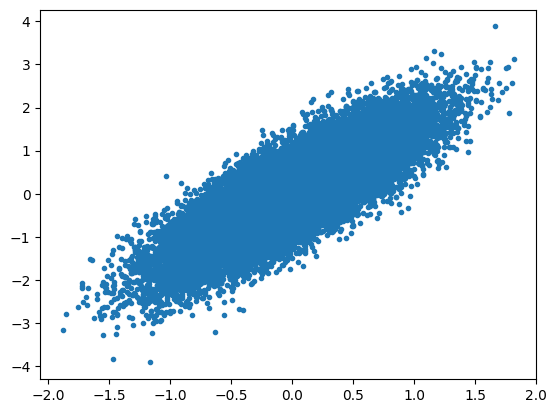

In [182]:
def genSignal(nToGen):
    _data = scipy.stats.multivariate_normal([0,0], [[0.3,0.7],[0.3,0.5]]).rvs(nToGen)
    return _data
sig_frame = genSignal(30000)
plt.scatter(sig_frame[:,0], sig_frame[:,1], marker = '.')

Now we make some background data that is in a ring around the signal distribution

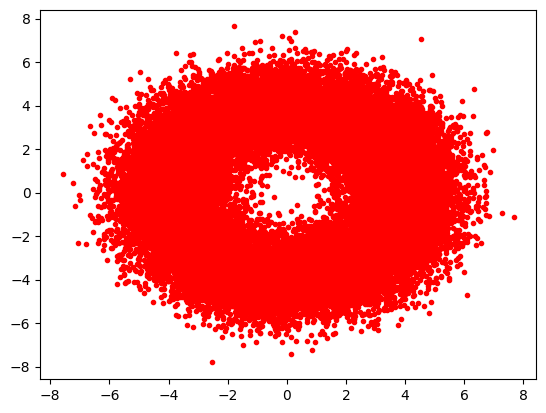

In [183]:
def genBkg(nToGen):
    th = random.random()*2.*math.pi
    r = 4
    _data = [scipy.stats.multivariate_normal([0,0], [[0.5,0.],[0.,0.5]]).rvs(1)]
    for i in range(nToGen):
        th = random.random()*2.*math.pi
        _data = np.append(_data, [scipy.stats.multivariate_normal([r*math.cos(th),r*math.sin(th)], [[1,0.],[0.,1.]]).rvs(1)], axis=0)
    return _data   
        

bkg_frame = genBkg(30000)
plt.scatter(bkg_frame[:,0], bkg_frame[:,1], marker = '.', color = 'r')

And plot the two together

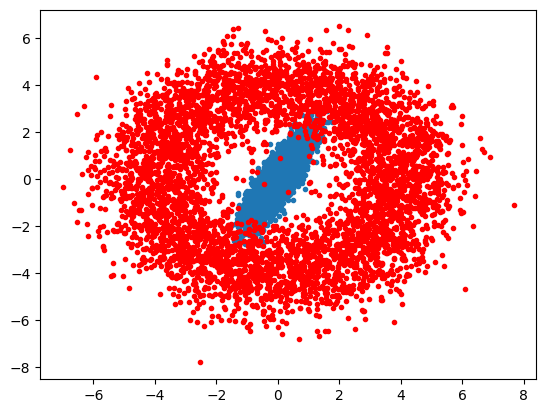

In [185]:
plt.scatter(sig_frame[:5000,0], sig_frame[:5000,1], marker = '.')
plt.scatter(bkg_frame[:5000,0], bkg_frame[:5000,1], marker = '.', color = 'r')

Let's look at the 1D distributions

(array([  40., 1077., 4533., 5219., 4001., 3986., 4941., 4826., 1325.,
          53.]),
 array([-7.81426194, -6.26907799, -4.72389405, -3.1787101 , -1.63352615,
        -0.08834221,  1.45684174,  3.00202568,  4.54720963,  6.09239358,
         7.63757752]),
 <BarContainer object of 10 artists>)

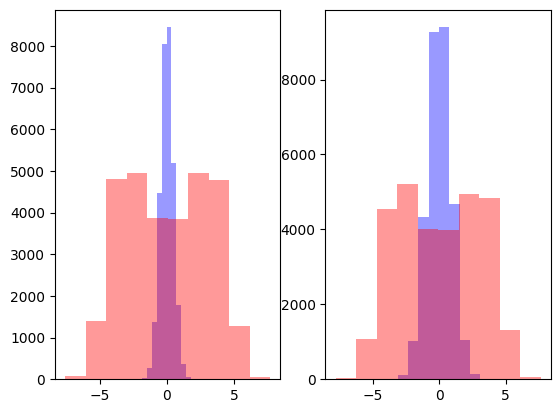

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(sig_frame[:,0], color = 'blue', alpha = 0.4)
ax1.hist(bkg_frame[:,0], color = 'red', alpha = 0.4)

ax2.hist(sig_frame[:,1], color = 'blue', alpha = 0.4)
ax2.hist(bkg_frame[:,1], color = 'red', alpha = 0.4)



Looking at the 1D projections we can probably make a fairly efficient selections by some 1D cuts. However the 2D projection shows that a circle would be better - an MVA is required.

For this example we should use a Boosted Decision Tree (BDT). It is a collection of decision trees, with ADABoost.

In [187]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

In [188]:
# First set up the BDT
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), algorithm="SAMME", n_estimators=200
)
# The max depth and number of estimators are two hyperparameters that can be tuned for optimal performance

# Now make a training data set from half the generated signal and background
# We make an array of the data and an array of labels for signal (1) and bkg (0)
X_train = np.concatenate([sig_frame[:15000], bkg_frame[:15000]])
Y_train = np.concatenate([np.ones(15000), np.zeros(15000)])
# We also make a statistically independent test set from the other half
X_test = np.concatenate([sig_frame[15000:30000], bkg_frame[15000:30000]])
Y_test = np.concatenate([np.ones(15000), np.zeros(15000)])

(array([1766.,  485., 2023., 2950., 5066.,  867.,  806.,  700.,  254.,
          83.]),
 array([0.30944681, 0.33440141, 0.35935601, 0.38431061, 0.40926521,
        0.4342198 , 0.4591744 , 0.484129  , 0.5090836 , 0.5340382 ,
        0.5589928 ]),
 <BarContainer object of 10 artists>)

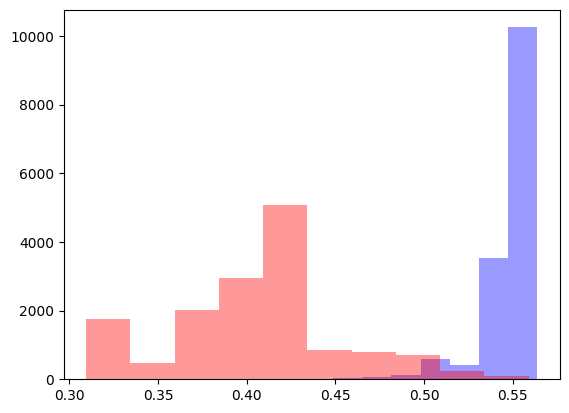

In [189]:
# Now fit the BDT to the training data and then see what it does to the test
bdt.fit(X,Y)
bdt_score = bdt.predict_proba(X_test)

# Plot the probability of label 1 (signal) for the signal and bkg samples
plt.hist(bdt_score[Y_test==1][:,1], color = 'blue', alpha= 0.4)
plt.hist(bdt_score[Y_test==0][:,1], color = 'red', alpha= 0.4)

We can visualise the decision boundary of the BDT. You can see the BDT has learned that the signal and background are separated by a circle and so learned that cut.

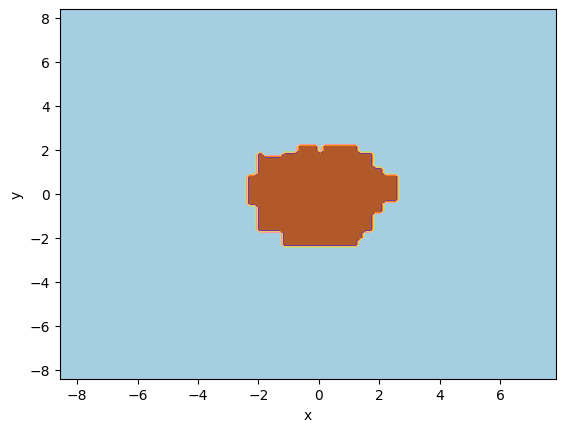

In [191]:
plt.figure()
ax = plt.gca()
disp = DecisionBoundaryDisplay.from_estimator(
    bdt,
    X_test,
    cmap=plt.cm.Paired,
    response_method="predict",
    ax=ax,
    xlabel="x",
    ylabel="y",
)